# Assignment 4

### 1. 复现代码

In [1]:
import numpy as np
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None
        self.gradients = {}

    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
            
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self): 
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    for n in graph:
        n.forward()
    for n in  graph[::-1]:
        n.backward()

def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]          
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []

In [3]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 167.948
Epoch: 101, Loss: 9.376
Epoch: 201, Loss: 7.369
Epoch: 301, Loss: 4.556
Epoch: 401, Loss: 4.082
Epoch: 501, Loss: 4.144
Epoch: 601, Loss: 3.926
Epoch: 701, Loss: 3.138
Epoch: 801, Loss: 3.062
Epoch: 901, Loss: 3.225
Epoch: 1001, Loss: 3.383
Epoch: 1101, Loss: 2.991
Epoch: 1201, Loss: 3.101
Epoch: 1301, Loss: 3.528
Epoch: 1401, Loss: 3.376
Epoch: 1501, Loss: 3.131
Epoch: 1601, Loss: 3.204
Epoch: 1701, Loss: 3.464
Epoch: 1801, Loss: 3.068
Epoch: 1901, Loss: 3.097
Epoch: 2001, Loss: 2.833
Epoch: 2101, Loss: 3.009
Epoch: 2201, Loss: 2.621
Epoch: 2301, Loss: 2.531
Epoch: 2401, Loss: 2.752
Epoch: 2501, Loss: 3.175
Epoch: 2601, Loss: 2.999
Epoch: 2701, Loss: 3.053
Epoch: 2801, Loss: 2.977
Epoch: 2901, Loss: 2.777
Epoch: 3001, Loss: 2.572
Epoch: 3101, Loss: 2.694
Epoch: 3201, Loss: 3.162
Epoch: 3301, Loss: 2.512
Epoch: 3401, Loss: 2.725
Epoch: 3501, Loss: 3.015
Epoch: 3601, Loss: 2.702
Epoch: 3701, Loss: 2.688
Epoch: 3801, Loss: 2.900
Epoc

In [4]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value
forward(l2,graph)

array([[49.96264802],
       [45.98761483],
       [49.96264802],
       [26.68424225],
       [35.06504003],
       [12.75159491],
       [22.38803858],
       [20.81659133],
       [23.96138384],
       [23.32035014],
       [12.65783748],
       [14.01510749],
       [35.74037155],
       [34.42588272],
       [23.65810747],
       [19.92409224]])

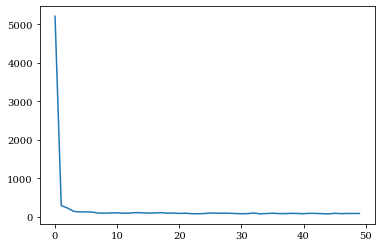

In [6]:
# Loss function
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

Ans: 
1.预测事物发生概率：将输入层的样本与各自的权重相乘，并加上常数，最后通过激活函数，即可作为输出层输出。该输出可以视为所预测事物发生的概率。
2.拟合一个复杂的函数：在样本参数不确定时，通过神经元的正向与反向传播，一次次更新参数，最终可以拟合一个复杂的函数。

####  2. Why we use non-linear activation funcitons in neural networks?

Ans: 线性激活函数会导致单层与多层神经网络效果一样。所以用飞线性激活函数。

#### 3. What is the 'Logistic Loss' ?

Ans: 在机器学习中，通常把模型关于单个样本预测值与真实值的差称为损失，损失越小，模型越好，而用于计算损失的函数称为损失函数。
$$Loss = -(y*log\hat{y} + (1-y)log(1-\hat{y}))$$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
√C. sigmoid    
D. tanh  
sigmoid取值范围为(0,1)，它可以将一个实数映射到(0,1)的区间，可以用来做二分类。

#### 5. Why we don't use zero initialization for all parameters ?

由于神经网络对称性问题。正向传播会使得每个输出层输出为0；反向传播使得每层梯度为0。换句话说，本来我们希望不同的结点学习到不同的参数，但是由于参数相同以及输出值都一样，不同的结点根本无法学到不同的特征！这样就失去了网络学习特征的意义了。
总结来看：w初始化全为0，很可能直接导致模型失效，无法收敛。

#### 6. Can you implement the softmax function using python ? 

In [476]:
def _softmax(self, x):
    return np.exp(X) / np.sum(np.exp(X))

### 3.实践题

In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .¶


### 3.0 Implement a two-layer neural network to predict picture categories and evaluate using cross-entropy and accuracy

#### 0 - Realize classes contains which can be used to build neural networks

In [200]:
import numpy as np
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None
        self.gradients = {}

    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
            
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self): 
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    for n in graph:
        n.forward()
    for n in  graph[::-1]:
        n.backward()

def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]          
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [439]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as n

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as 0 if the digit < 5 or 1 if the digit >= 5
    - each image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [440]:
# Loading the data 
digits = datasets.load_digits()

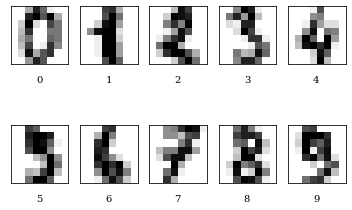

In [372]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)#划分成2行5列
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])#设置坐标轴显示的刻度，此时值为空
    plt.yticks([])
plt.show()

In [373]:
# Split the data into training set and test set 
#train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)#test_size表示样本占比

In [ ]:
n_features = X_train.shape[1]
n_hidden = 4
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [399]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [400]:
len(y_train)

1347

In [401]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347, 1)
(450, 1)


In [208]:
# build neural network
losses = []
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input(
l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
s2 = Sigmoid(l2)
cost = MSE(y, s2)

feed_dict = {
    X: X_train,
    y: y_train,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000 #How many layers did the data run
# Total number of examples
m = X_train.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size #m/batchsize
graph = topological_sort(feed_dict) # build graph
trainables = [W1, b1, W2, b2] # Trainable parameters
print("Total number of examples = {}".format(m))

# update neural network
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_train, y_train, n_samples=batch_size)
        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch
        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.
        # Step 3
        rate = 1e-2
        sgd_update(trainables, rate)
        loss += graph[-1].value    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 1347
Epoch: 1, Loss: 0.254
Epoch: 101, Loss: 0.247
Epoch: 201, Loss: 0.231
Epoch: 301, Loss: 0.199
Epoch: 401, Loss: 0.177
Epoch: 501, Loss: 0.174
Epoch: 601, Loss: 0.154
Epoch: 701, Loss: 0.144
Epoch: 801, Loss: 0.133
Epoch: 901, Loss: 0.130
Epoch: 1001, Loss: 0.118
Epoch: 1101, Loss: 0.115
Epoch: 1201, Loss: 0.094
Epoch: 1301, Loss: 0.094
Epoch: 1401, Loss: 0.073
Epoch: 1501, Loss: 0.068
Epoch: 1601, Loss: 0.074
Epoch: 1701, Loss: 0.065
Epoch: 1801, Loss: 0.060
Epoch: 1901, Loss: 0.059
Epoch: 2001, Loss: 0.058
Epoch: 2101, Loss: 0.062
Epoch: 2201, Loss: 0.054
Epoch: 2301, Loss: 0.050
Epoch: 2401, Loss: 0.048
Epoch: 2501, Loss: 0.039
Epoch: 2601, Loss: 0.043
Epoch: 2701, Loss: 0.048
Epoch: 2801, Loss: 0.037
Epoch: 2901, Loss: 0.037
Epoch: 3001, Loss: 0.042
Epoch: 3101, Loss: 0.046
Epoch: 3201, Loss: 0.044
Epoch: 3301, Loss: 0.035
Epoch: 3401, Loss: 0.040
Epoch: 3501, Loss: 0.030
Epoch: 3601, Loss: 0.034
Epoch: 3701, Loss: 0.030
Epoch: 3801, Loss: 0.031
Epoch

In [210]:
def predict(outputNode,graph,X_test,W1,b1,W2,b2):
    X_ = X_test
    W1_ = W1
    b1_ = b1
    W2_ = W2
    b2_ = b2
    
    # Neural network
    X = Input()
    W1, b1 = Input(), Input()
    W2, b2 = Input(), Input()
    l1 = Linear(X, W1, b1)
    s1 = Sigmoid(l1)
    l2 = Linear(s1, W2, b2)
    s2 = Sigmoid(l2)
    
    feed_dict = {
    X: X_test,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
    }
    graph = topological_sort(feed_dict) # build graph
    trainables = [W1, b1, W2, b2] # Trainable parameters
    for n in graph:
        n.forward()
        predict_propability=[]
    for i in s2.value:
        predict_propability+=(i.tolist())
    return predict_propability
list_prediction=(predict(s2,graph,X_test,W1.value,b1.value,W2.value,b2.value))
list_prediction

[0.9577475136009836,
 0.1782188112733877,
 0.9577475398115515,
 0.9577475396187515,
 0.0527036631925396,
 0.05270366319254488,
 0.05270156349321922,
 0.03472773189781064,
 0.9575974034084781,
 0.9572667110104426,
 0.9577475290834409,
 0.9205566765067161,
 0.03472717871096306,
 0.9577475398115517,
 0.9577019210669326,
 0.9577475398096439,
 0.9577475396520564,
 0.9577475398115517,
 0.034727178707260484,
 0.9577475335161852,
 0.957747539726801,
 0.9577475398115517,
 0.03472770337691424,
 0.0529734030644532,
 0.9577475398115166,
 0.05270366241477963,
 0.9577475397728304,
 0.05270366322685853,
 0.9577459438443685,
 0.03472717870735156,
 0.034727178707260484,
 0.9577475398113672,
 0.03472717868827621,
 0.05270366319254453,
 0.03472717870724837,
 0.052703663192398026,
 0.03472717870749292,
 0.9577475398115517,
 0.18771866353176558,
 0.9577475398115517,
 0.9577475398115517,
 0.755082235219335,
 0.9577475398115517,
 0.03472717853856478,
 0.9577475398113148,
 0.9577475228280165,
 0.0347271787415

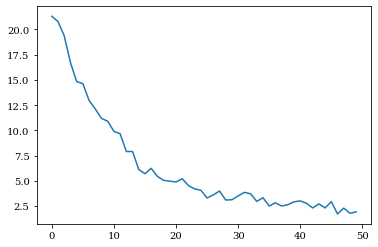

In [211]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)

交叉熵刻画的是通过概率分布q来表达概率分布p的困难程度，其中p是正确答案，q是预测值，也就是交叉熵值越小，两个概率分布越接近

In [212]:
import math
# Write a function that takes as input two lists Y, P,
# and returns the float corresponding to their cross-entropy.
def cross_entropy(Y, P):
    sum=0.0
    for x in map(lambda y,p:(1-y)*math.log(1-p)+y*math.log(p),Y,P):
        sum+=x
    return -sum/len(Y)

cross_entropy(y_test,list_prediction)

0.3061572000297909

#### 3.1 Build a logistic regression model to predict image types
#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as 0 if the digit < 5 or 1 if the digit >= 5
    - each image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

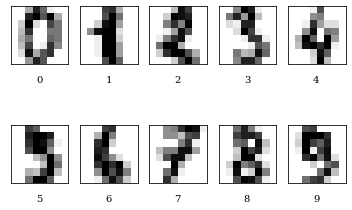

In [449]:
# Loading the data 
digits = datasets.load_digits()
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)#划分成2行5列
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])#设置坐标轴显示的刻度，此时值为空
    plt.yticks([])
plt.show()
# Split the data into training set and test set 
#train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)#test_size表示样本占比
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#### 3- Architecture of the neural network

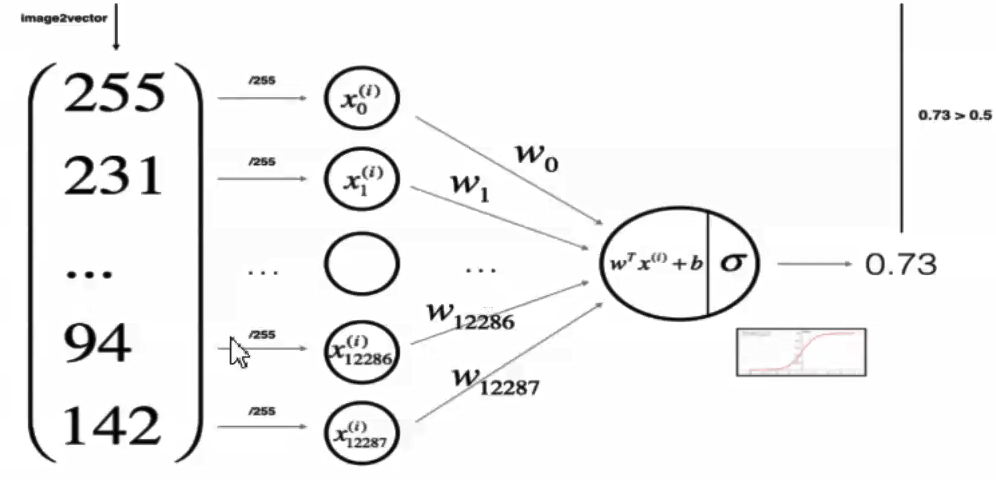

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [450]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1/(1 + np.exp(-1 * z))
    
    return s

In [451]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [452]:
# Random innitialize the parameters
import random
def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    w = np.random.randn(dim, 1)
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [453]:
initialize_parameters(10)

(array([[-0.77439202],
        [ 0.42164132],
        [ 1.49501035],
        [ 0.72833819],
        [ 0.88715052],
        [-1.24083557],
        [-0.88637176],
        [ 0.27769334],
        [ 0.73412169],
        [-0.76787461]]), 0)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [471]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[0]
    A = sigmoid(np.dot(X,w)+b)
    cost = sum(-y*np.log(a)-(1-y)*np.log(1-a) for y,a in zip(Y,A))/ m 
#     print(cost)
    dw = np.dot(X.T,(A-Y)) / m
    db = sum(a-y for y,a in zip(Y,A))/ m 

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [455]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [456]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    Y_prediction = np.zeros((m,1),dtype=np.int)
    A = sigmoid(np.dot(X,w)+b)
    for i in range(A.shape[0]):
        if A[i,0]>0.5:
            Y_prediction[i,0] = 1
    
    assert(Y_prediction.shape == (m,1))
    return Y_prediction

In [457]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w,b=initialize_parameters(X_train.shape[1])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate,print_cost)
    w=params['w']
    b=params['b']

    Y_train_prediction=predict(w,b,X_train)
    traing_accuracy=sum(Y_train==Y_train_prediction)/(Y_train.shape[0])
    Y_test_prediction=predict(w,b,X_test)
    test_accuracy=sum(Y_test==Y_test_prediction)/(Y_test.shape[0])
    d = {"w":w,"b":b,"training_accuracy": traing_accuracy,"test_accuracy":test_accuracy,"cost":costs}
    return d    

##### 5- Merge all functions into a model

In [447]:
model(X_train, y_train, X_test, y_test, num_iterations=5000, learning_rate=1e-2,print_cost=True)

E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: 1.124912
Cost after iteration 500: 0.881061
Cost after iteration 600: 0.721291
Cost after iteration 700: 0.615152
Cost after iteration 800: 0.543009
Cost after iteration 900: 0.491246
Cost after iteration 1000: 0.452425
Cost after iteration 1100: 0.422452
Cost after iteration 1200: 0.398782
Cost after iteration 1300: 0.379755
Cost after iteration 1400: 0.364279
Cost after iteration 1500: 0.351592
Cost after iteration 1600: 0.341125
Cost after iteration 1700: 0.332439
Cost after iteration 1800: 0.325194
Cost after iteration 1900: 0.319120
Cost after iteration 2000: 0.314004
Cost after iteration 2100: 0.309672
Cost after iteration 2200: 0.305983
Cost after iteration 2300: 0.302823
Cost after iteration 2400: 0.300096
Cost after iteration 2500: 0.297727
Cost after iteration 2600: 0.295651
Cost after iteration 2700: 0.293817
Cost after iteration 280

{'w': array([[-0.5642116 ],
        [ 1.08235882],
        [ 0.10560453],
        [-0.00816431],
        [ 0.10902894],
        [ 0.06350084],
        [ 0.09780826],
        [ 1.12654584],
        [ 0.33342712],
        [-0.24269419],
        [ 0.14348413],
        [ 0.11521817],
        [-0.06178928],
        [-0.00450669],
        [ 0.09933667],
        [-1.19263304],
        [-1.1057854 ],
        [ 0.11402208],
        [ 0.17562475],
        [ 0.00507438],
        [-0.21837059],
        [-0.14435788],
        [-0.10646702],
        [ 0.14621485],
        [ 0.61783599],
        [-0.26099102],
        [ 0.02466722],
        [ 0.16506392],
        [ 0.04794591],
        [ 0.205466  ],
        [-0.18773088],
        [-0.58099176],
        [ 1.36935057],
        [-0.21327481],
        [-0.0195126 ],
        [ 0.22526885],
        [-0.14196229],
        [-0.01658913],
        [ 0.0553179 ],
        [ 0.22471892],
        [ 2.20030101],
        [-0.19236989],
        [ 0.07515509],
      

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the learning process.   
Hits: plot the learning curve with different learning rate

E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 0: 50.855294
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after i

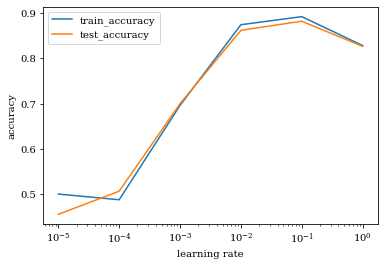

In [462]:
import matplotlib.pyplot as plt
%matplotlib inline
lrs = np.logspace(-5, 0, 6)
test_acc_dict, train_acc_dict = [], []
for lr in lrs:
    d = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=lr,print_cost=True)
    train_acc_dict.append(d['training_accuracy'])
    test_acc_dict.append(d['test_accuracy'])
fig, ax = plt.subplots()
ax.set_xscale('log')#Set the x-axis to log
ax.plot(lrs, train_acc_dict, label='train accuracy')
ax.plot(lrs, test_acc_dict, label='test accuracy')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
ax.legend()# add plot

当学习率大于10^-4时，train accuracy和test accuray开始提高；
在学习率在0.01左右时，train accuracy和test accuray最高。

##### 4.2 Observe the effect of iteration_num on the test accuracy.

E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Cost after iteration 0: nan
Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after 

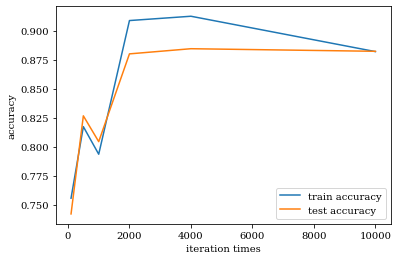

In [477]:
iters = [100,500,1000,2000,4000,10000]
train_acc_dict, test_acc_dict = [], []
for num in iters:
    d = model(X_train, y_train, X_test, y_test, num_iterations=int(num), learning_rate=1e-1,print_cost=True)
    train_acc_dict.append(d['training_accuracy'])
    test_acc_dict.append(d['test_accuracy'])
fig, ax = plt.subplots()
ax.plot(iters, train_acc_dict, label='train accuracy')
ax.plot(iters, test_acc_dict, label='test accuracy')
plt.xlabel('iteration times')
plt.ylabel('accuracy')
ax.legend()

当迭代次数超过2000时，training accuracy和test accuracy都会保持在很高的百分比（87%以上）。随着迭代次数的继续增加，training accuracy和test accuracy会趋于一致。

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 